Now that we have learn about random walks and diffusion, let us work an example step by step. We are going to simulate the diffusion of a drop of dye in water.

Ok, one approache would be to solve the dynamical equations of each of the particles you have in the drop, let say Avogrado's number. This is already VERY difficult for several reasons

+ It is too big and storing the positions and velocities of each one of them would be impossible.

+ Assuming we reduce the problem, the question is that we will need to solve the equations of motion on each iteration. Maybe too demanding before we see any change

Therefore, the best is now using stochastic methods.

Ok, now we need to upload the basic packages

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy

Now, the next step is to create the dye, we are going to assume that we have N number of particles (defined by the user) and they are going to be sitting within a circle (in the example below, I am assuming only 2D but generalization would be simple, though the GUI will take more time.

In [2]:
#radii of circle
r0=1.0

rmax=5.0
rmax2=rmax*rmax

#Number of particles
npart=200
#dimensionality of my problem
ndim=2

# we will see why we use sqrt(random) below
r = r0 * np.sqrt(np.random.rand(npart))
theta = np.random.rand(npart) * 2 * np.pi

x = r * np.cos(theta)
y = r * np.sin(theta)

old=np.array([x,y])

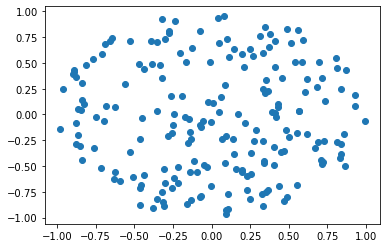

In [3]:
plt.plot(x,y,'o')

The average distance between points should be the same regardless of how far from the center we look. For example points at r=0.25 should have the same "density" for r=0.5. This means that we need the double of points at r=0.5 to maintain the density, right?

Now, since the length of the circle goes as 2πr, therefore the number of points that needs to be created go linear with r. In other words, the desired probability density function (PDF) grows linearly. Since a PDF should have an area equal to 1 and the maximum radius is r0 (which in this example we have defined to be 1.0), then $PDF(r)=2r$. 

Now, we want to simulate this PDF, how? use the trick of the inversion sampling.

Let us go a bit deeper

Using Wikipedia

"Inverse transform sampling (also known as inversion sampling, the inverse probability integral transform, the inverse transformation method, Smirnov transform, or the golden rule[1]) is a basic method for pseudo-random number sampling, i.e., for generating sample numbers at random from any probability distribution given its cumulative distribution function."

Now?


+ From the PDF, create the cumulative distribution function (CDF)
    
+ Mirror this along y = x

+ Apply the resulting function to a uniform value between 0 and 1.


Step 1: Create the CDF:

Since we're working with reals, the CDF is expressed as the integral of the PDF.

$CDF(x) = \int 2x = x^2$

Step 2: Mirror the CDF along y = x:

Mathematically this boils down to swapping x and y and solving for y:

CDF:     $y = x^2$

Swap:   $x = y^2$

Solve:   $y = \sqrt{x}$

CDF$^{-1}$:  $y = \sqrt{x}$

Step 3: Apply the resulting function to a uniform value between 0 and 1

CDF$^{-1}$(random()) = $\sqrt{\text{random()}}$




In [4]:
#Allow animation
plt.ion()

# set up graph window
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [5]:
def circle_line_segment_intersection(circle_center, circle_radius, pt1, pt2, full_line=True, tangent_tol=1e-9):
    """ Find the points at which a circle intersects a line-segment.  This can happen at 0, 1, or 2 points.

    :param circle_center: The (x, y) location of the circle center
    :param circle_radius: The radius of the circle
    :param pt1: The (x, y) location of the first point of the segment
    :param pt2: The (x, y) location of the second point of the segment
    :param full_line: True to find intersections along full line - not just in the segment.  False will just return intersections within the segment.
    :param tangent_tol: Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
    :return Sequence[Tuple[float, float]]: A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

    Note: We follow: http://mathworld.wolfram.com/Circle-LineIntersection.html
    """

    (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
    (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
    dx, dy = (x2 - x1), (y2 - y1)
    dr = (dx ** 2 + dy ** 2)**.5
    big_d = x1 * y2 - x2 * y1
    discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

    if discriminant < 0:  # No intersection between circle and line
        return []
    else:  # There may be 0, 1, or 2 intersections with the segment
        intersections = [
            (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
             cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
            for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
        if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
            fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
            intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
        if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
            return [intersections[0]]
        else:
            return intersections

In [6]:
d=circle_line_segment_intersection([0,0], 2.0, [0,0], [3,0],True)
print(np.array(d))

[[-2.  0.]
 [ 2.  0.]]


Press return to continue


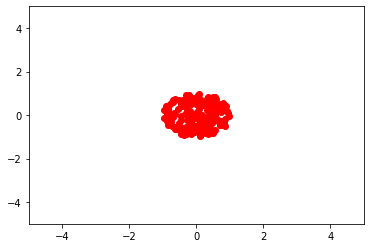

In [7]:
#show initial configuration

line, = plt.plot(old[0,:], old[1,:], 'ro')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.draw()

wait = input("Press return to continue")

In [9]:
# Number of steps

N = 100

p=np.zeros(2)

for i in range(N):

    #print('iteration =',i)
    r = 0.1*np.sqrt(np.random.rand(npart))
    theta = np.random.rand(npart) * 2 * np.pi
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    new = old + np.array([x,y])
    r = np.sum(new**2,axis=0)

    for j in range (npart):
            oldpos=old[:,j]
            newpos=new[:,j]
            
            while np.linalg.norm(newpos)> rmax:
                
                out=np.array(circle_line_segment_intersection([0,0], rmax, oldpos, newpos, True))
                d1=np.sqrt((out[0,0]-newpos[0])**2+(out[0,1]-newpos[1])**2)
                d2=np.sqrt((out[1,0]-newpos[0])**2+(out[1,1]-newpos[1])**2)
                if d1<d2:
                    p[0]=out[0,0]
                    p[1]=out[0,1]
                else:
                    p[0]=out[1,0]
                    p[1]=out[1,1]
                a=newpos-p #Find the vector from the intersection point to the new point
                newpos=newpos-2*(np.dot(p,a)/np.linalg.norm(p)**2)*p
                oldpos=p
                
            old[:,j]=newpos
            new[:,j]=oldpos
     
    if (i%20 == 0):
    # See how things look now.
        line.set_xdata(new[0,:])
        line.set_ydata(new[1,:])
        plt.draw()
        #wait = input("Press return to exit")